# Electroencephalography (EEG) Signal Classification using Deep Learning

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
RANDOM_STATE = 42  # for reproducibility
np.random.seed(RANDOM_STATE)

In [4]:
import os
os.chdir("../")
DATA_DIR = "./data/raw/BCI_Comp_III_Wads_2004/"

## Read in the data from .mat

In [5]:
from src.data.io import load_data_from_mat

In [6]:
train = load_data_from_mat(DATA_DIR + "Subject_A_Train.mat")
test = load_data_from_mat(DATA_DIR + "Subject_A_Test.mat")

In [7]:
train

{'Flashing': array([[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]], dtype=float32),
 'Signal': array([[[ 8.0849998e-02, -1.7930571e+01, -9.2669497e+00, ...,
          -1.9443050e+01, -1.0342620e+01, -1.4575340e+01],
         [-2.2476299e+00, -1.7676010e+01, -6.4597502e+00, ...,
          -1.7911850e+01, -8.0227804e+00, -1.3052780e+01],
         [ 7.5837302e+00, -1.4875850e+01, -3.3973501e+00, ...,
          -1.4083850e+01, -4.1563802e+00, -9.7538996e+00],
         ...,
         [-2.6567310e+01, -1.4366730e+01, -2.4068550e+01, ...,
           5.0561500e+00, -1.3210200e+00,  3.9491401e+00],
         [-2.1651630e+01, -1.2330250e+01, -2.0750950e+01, ...,
           9.7294998e-01, -2.0943000e+00,  1.1577801e+00],
         [-2.2169069e+01, -1.5130410e+01, -2.4068550e+01, ...,
          -1.3238500e+00, -

In [8]:
test

{'Flashing': array([[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]], dtype=float32),
 'Signal': array([[[-1.621851e+01, -1.411217e+01, -9.777350e+00, ...,
          -1.918785e+01, -1.987974e+01,  1.411540e+00],
         [-1.285515e+01, -1.385761e+01, -1.003255e+01, ...,
          -2.454705e+01, -2.323062e+01, -4.171180e+00],
         [-1.259643e+01, -1.385761e+01, -1.003255e+01, ...,
          -2.811985e+01, -2.606598e+01, -1.000766e+01],
         ...,
         [-1.621851e+01, -1.614865e+01, -1.232935e+01, ...,
          -3.030500e-01,  4.607460e+00,  9.040200e-01],
         [-1.285515e+01, -1.334849e+01, -1.079815e+01, ...,
          -2.344650e+00,  2.545380e+00,  1.427400e-01],
         [-1.440747e+01, -1.742145e+01, -1.513655e+01, ...,
          -5.407050e+00, -1.321020e+00, -2.902380e+00]],
 
 

In [9]:
train.keys()

dict_keys(['TargetChar', 'Flashing', 'StimulusType', 'Signal', 'StimulusCode'])

In [10]:
test.keys()

dict_keys(['Flashing', 'Signal', 'StimulusCode'])

## Preprocessing

In [11]:
NUM_CHARS, NUM_SAMPLES, NUM_ELECTRODES = train['Signal'].shape
print(NUM_CHARS, NUM_SAMPLES, NUM_ELECTRODES)

85 7794 64


In [12]:
# 6 rows + 6 cols
NUM_ROWCOLS = 12

# Each character is runned for 15 times, so 12 * 15 = 180 intensifies
NUM_REPEAT = 15

# Sampling frequency is 240Hz
FS = 240

# After the simulation, 0.65s of data is treated as a sample
SECONDS_TO_SLICE = 0.65    

In [13]:
from src.data.preprocessing import transform
train = transform(train, FS, NUM_ROWCOLS, NUM_REPEAT, SECONDS_TO_SLICE)
test = transform(test, FS, NUM_ROWCOLS, NUM_REPEAT, SECONDS_TO_SLICE)

In [14]:
train.keys()

dict_keys(['code', 'label', 'signal', 'targetchar'])

In [15]:
test.keys()

dict_keys(['code', 'signal'])

In [16]:
train['signal'].shape

(85, 15, 12, 64, 156)

In [17]:
print(train['label'].shape)
print(train['targetchar'].shape)
print(train['code'].shape)

(85, 15, 12)
(85,)
(85, 15, 12)


In [18]:
from src.data.preprocessing import subsample, butter_bandpass_filter, standardize_along

for d in [train, test]:

    subsample_interval = 2

    d['signal'] = subsample(d['signal'], subsample_interval)

    lowcut = 0.1
    highcut = 20
    order = 5
    FS_subsampled = int(FS/subsample_interval)
    d['signal'] = butter_bandpass_filter(d['signal'], lowcut, highcut,
                                             FS_subsampled, order, -1)

    d['signal'] = standardize_along(d['signal'], -1).reshape([-1, NUM_ELECTRODES, 
                                                            d['signal'].shape[-1], 1])


In [19]:
train['signal'].shape

(15300, 64, 78, 1)

In [20]:
test['signal'].shape

(18000, 64, 78, 1)

In [21]:
train['label'].shape

(85, 15, 12)

In [22]:
train['label'][0][0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.])

In [23]:
train['label'] = to_categorical(train['label'].reshape([-1, ]))

## Training

In [24]:
X_train, X_val, y_train, y_val = train_test_split(train['signal'], train['label'], test_size=0.05,
                                                  random_state=RANDOM_STATE, stratify=train['label'])

In [25]:
from src.models.PAMI import CNN_P300_PAMI
model = CNN_P300_PAMI(train['signal'].shape[1:])
model.compile(optimizer = 'sgd',loss = 'binary_crossentropy',metrics = ['acc', 'mse'])

In [26]:
earlystopping = EarlyStopping(monitor = "val_mean_squared_error",patience = 3)

In [27]:
model.fit(x = X_train, y = y_train, batch_size=32, epochs = 1000, callbacks = [earlystopping], 
              validation_data = [X_val,y_val])

Train on 14535 samples, validate on 765 samples
Epoch 1/1000
14535/14535 [==============================] - 11s - loss: 0.4536 - acc: 0.8320 - mean_squared_error: 0.1404 - val_loss: 0.4467 - val_acc: 0.8327 - val_mean_squared_error: 0.1379
Epoch 2/1000
14535/14535 [==============================] - 5s - loss: 0.4428 - acc: 0.8334 - mean_squared_error: 0.1367 - val_loss: 0.4422 - val_acc: 0.8327 - val_mean_squared_error: 0.1366
Epoch 3/1000
14535/14535 [==============================] - 5s - loss: 0.4381 - acc: 0.8334 - mean_squared_error: 0.1354 - val_loss: 0.4388 - val_acc: 0.8327 - val_mean_squared_error: 0.1355
Epoch 4/1000
14535/14535 [==============================] - 5s - loss: 0.4340 - acc: 0.8334 - mean_squared_error: 0.1342 - val_loss: 0.4346 - val_acc: 0.8327 - val_mean_squared_error: 0.1344
Epoch 5/1000
14535/14535 [==============================] - 5s - loss: 0.4296 - acc: 0.8334 - mean_squared_error: 0.1329 - val_loss: 0.4301 - val_acc: 0.8327 - val_mean_squared_error: 0.1

## Testing

In [28]:
test.keys()

dict_keys(['code', 'signal'])

In [29]:
test['signal'].shape

(18000, 64, 78, 1)

In [30]:
test['code'].shape

(100, 15, 12)

In [32]:
with open(DATA_DIR + "A_test_labels.txt") as f:
    answer = f.readline()

In [33]:
from src.models.PAMI import testing_pipeline
model_scores = testing_pipeline(test, model, "all", answer)
print(model_scores)

[0.17, 0.36, 0.5, 0.56, 0.63, 0.68, 0.69, 0.78, 0.82, 0.83, 0.83, 0.86, 0.86, 0.92, 0.92]


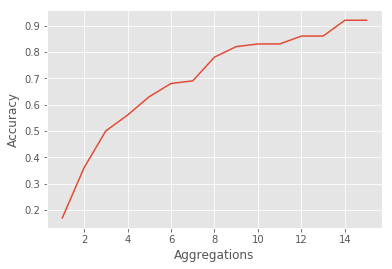

In [34]:
plt.style.use("ggplot")
plt.plot(np.arange(15)+1, model_scores)
plt.xlabel("Aggregations")
plt.ylabel("Accuracy")
plt.grid(True)